In [1]:
# Import packages
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

In [3]:
#suppl = Chem.SDMolSupplier('vs_seval_top2000.sd')
suppl = Chem.SDMolSupplier('VS_SPECS/specs_raw_hits_top1000.sd')
suppl

In [4]:
#mols = [x for x in suppl]
mols = [(x,x.GetProp("Name")) for x in suppl]
print('Set with %d molecules loaded'%(len(mols)))
#mols
mols[0:5]

Set with 999 molecules loaded


[(<rdkit.Chem.rdchem.Mol at 0x7fb04a4badf0>,
  '2c8fd8433150df1da9295743e4bc31bc2d771f94d070a8bf91dfddb5b3e82cb2'),
 (<rdkit.Chem.rdchem.Mol at 0x7fb04a4bae90>,
  'e823ffcbd56ded3b05bcf7059acefb79647a15326eec4fd49c5495a74435d1a4'),
 (<rdkit.Chem.rdchem.Mol at 0x7fb04a4baee0>,
  '93d9afad1980a3c1ec57b88f4aab57f2a6488745b2e84b069771066870150e16'),
 (<rdkit.Chem.rdchem.Mol at 0x7fb04a4baf30>,
  '804f1b49677bca9f7b52772a0d32a8a6376c65136cc31f549ff8145fa420dcd0'),
 (<rdkit.Chem.rdchem.Mol at 0x7fb04a4baf80>,
  '4336726ed28cf38c867d02ce906fd40a0faa57074aabb8f9d0b93396aa3759dc')]

In [5]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m,idx in mols]
# How many compounds/fingerprints do we have?
print('Number of compounds converted:',len(fingerprints))
print('Fingerprint length per compound:',len(fingerprints[0]))


Number of compounds converted: 999
Fingerprint length per compound: 2048


In [6]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [7]:
# Example: Calculate single similarity of two fingerprints
sim = DataStructs.TanimotoSimilarity(fingerprints[0],fingerprints[1])
print ('Tanimoto similarity: %4.2f, distance: %4.2f' %(sim,1-sim))
sim = DataStructs.TanimotoSimilarity(fingerprints[0],fingerprints[2])
print ('Tanimoto similarity: %4.2f, distance: %4.2f' %(sim,1-sim))
sim = DataStructs.TanimotoSimilarity(fingerprints[0],fingerprints[7])
print ('Tanimoto similarity: %4.2f, distance: %4.2f' %(sim,1-sim))

Tanimoto similarity: 0.65, distance: 0.35
Tanimoto similarity: 0.66, distance: 0.34
Tanimoto similarity: 0.64, distance: 0.36


In [8]:
# Example: Calculate distance matrix (distance = 1-similarity)
Tanimoto_distance_matrix(fingerprints)[0:10]

[0.34764826175869123,
 0.33958333333333335,
 0.24373576309794986,
 0.16306954436450838,
 0.48670756646216773,
 0.48124999999999996,
 0.05568445475638051,
 0.30833333333333335,
 0.3416149068322981,
 0.21345707656612534]

In [9]:
# Side note: That looked like a list and not a matrix. 
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n*(n-1))/2
print(int(elem_triangular_matr), len(Tanimoto_distance_matrix(fingerprints)))

498501 498501


In [10]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps,cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [11]:
# Run the clustering procedure for the dataset
clusters = ClusterFps(fingerprints,cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  416
# clusters with only 1 compound:  281
# clusters with >5 compounds:  29
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


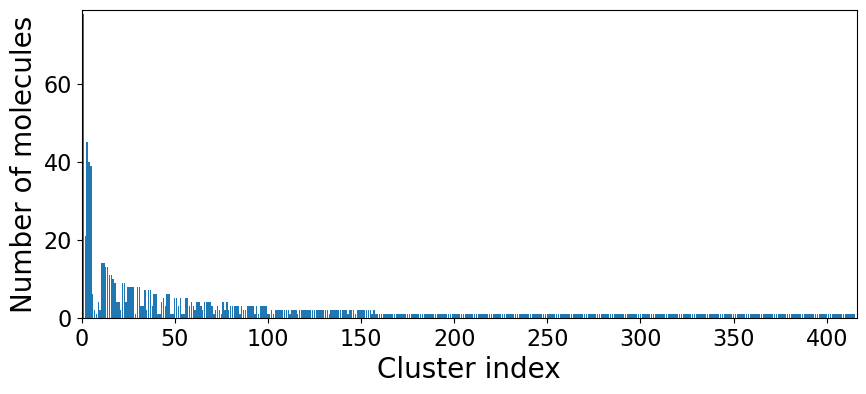

In [12]:
# Plot the size of the clusters
fig = plt.figure(1, figsize=(10, 4))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('Number of molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.show()

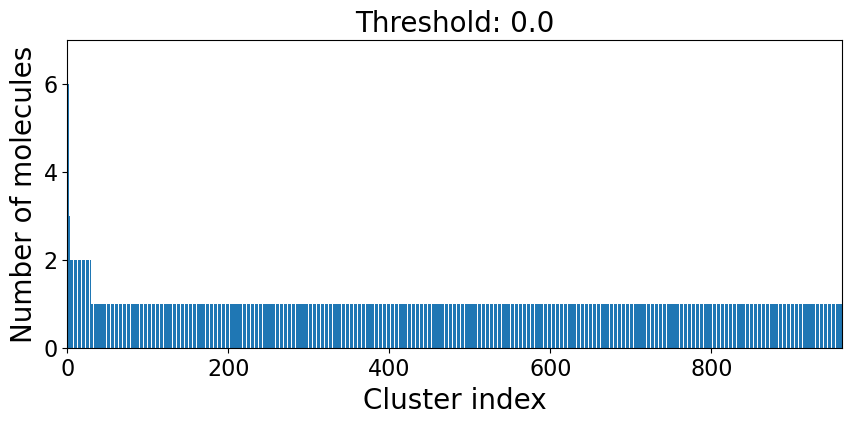

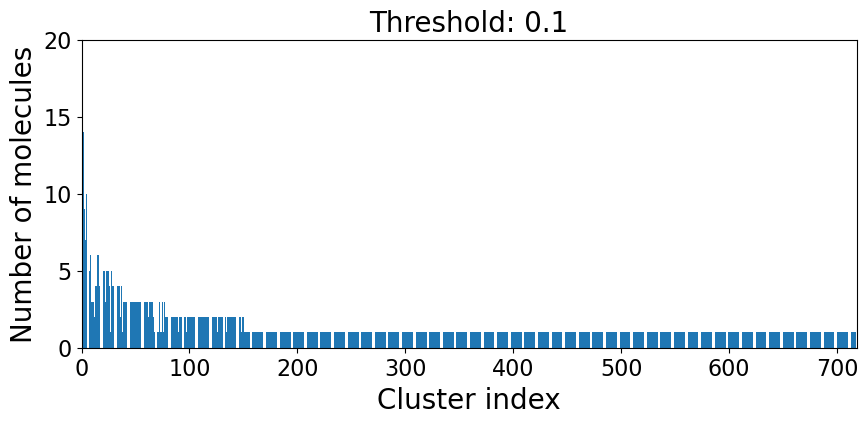

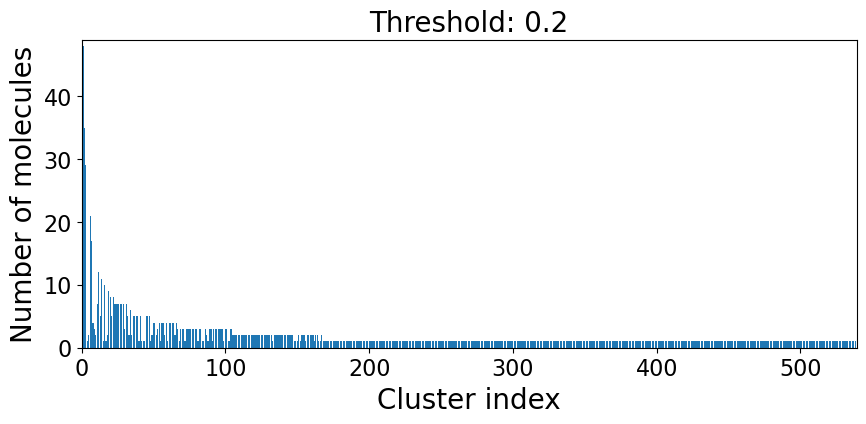

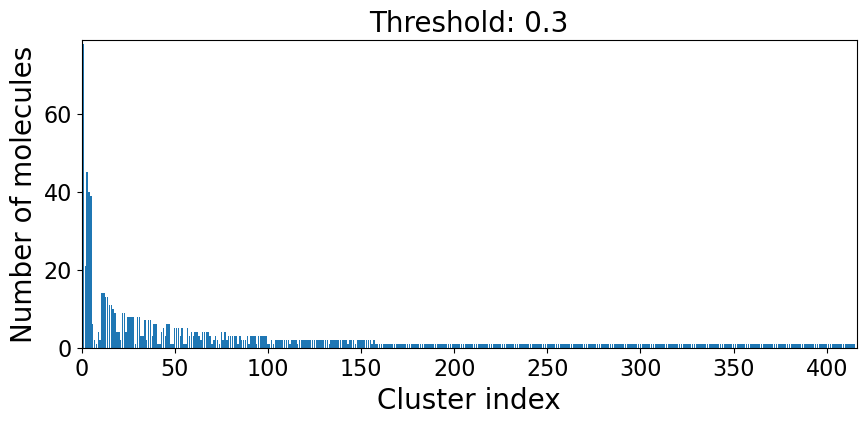

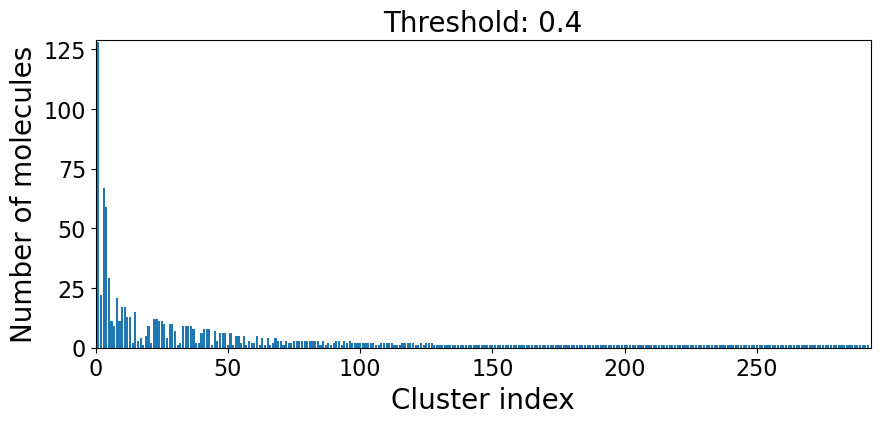

In [13]:
for i in numpy.arange(0., 0.5, 0.1):
    clusters = ClusterFps(fingerprints,cutoff=i)
    fig = plt.figure(1, figsize=(10, 4))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %i), fontsize=20)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

Number of clusters 539 from 999 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 48
Similarity between two random points in same cluster 0.88
Similarity between two random points in different cluster 0.65


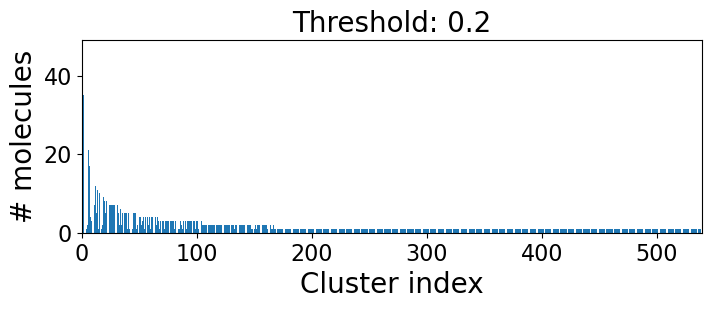

In [14]:
dist_co = 0.2
clusters = ClusterFps(fingerprints,cutoff=dist_co)

# Plot the size of the clusters - save plot
fig = plt.figure(1, figsize=(8, 2.5))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('# molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.title('Threshold: '+str('%3.1f' %dist_co), fontsize=20)
plt.savefig("cluster_dist_cutoff_%4.2f.png" %dist_co, dpi=300, bbox_inches="tight", transparent=True)

print('Number of clusters %d from %d molecules at distance cut-off %4.2f' %(len(clusters), len(mols), dist_co))
print('Number of molecules in largest cluster:', len(clusters[0]))
print('Similarity between two random points in same cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[0][1]]))
print('Similarity between two random points in different cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[1][0]]))

In [15]:
#print ('Ten molecules from largest cluster:')
## Draw molecules
#Draw.MolsToGridImage([mols[i][0] for i in clusters[0][:10]], 
#                     legends=[mols[i][1] for i in clusters[0][:10]], 
#                     molsPerRow=5)

In [19]:
# Save molecules from largest cluster for MCS analysis in Talktorial 9
#w = Chem.SDWriter('molSet_largestCluster2.sdf')

# Prepare data
##SRC, repeat for first 10 clusters
#in order to select molecules from cluster afterwards
clus_sort=sorted(clusters, key = lambda i: len(i), reverse=True)
#print(clus_sort)
for clid in range(0,200):
    # Save molecules from largest cluster for MCS analysis in Talktorial 9
    if clid < 10:
        w = Chem.SDWriter('CLUSTERS/cluster_00'+str(clid)+'_mols.sdf')
    elif clid < 100:
        w = Chem.SDWriter('CLUSTERS/cluster_0'+str(clid)+'_mols.sdf')
    else:
        w = Chem.SDWriter('CLUSTERS/cluster_'+str(clid)+'_mols.sdf')
    tmp_mols=[]
    for i in clus_sort[clid]:
        tmp = mols[i][0]
        tmp.SetProp("_Name",mols[i][1])
        tmp_mols.append(tmp)  
    
    # Write data
    for m in tmp_mols: w.write(m)
        
#d=sorted(k, key = lambda i: len(i), reverse=True)
#[len(c) for c in clus_sort]

In [20]:
w = Chem.SDWriter('CLUSTERS/cluster_199_mols.sdf')
tmp_mols=[]
for i in clus_sort[199]:
    tmp = mols[i][0]
    tmp.SetProp("_Name",mols[i][1])
    tmp_mols.append(tmp)
        
for m in tmp_mols: w.write(m) 

In [21]:
#print ('Ten molecules from second largest cluster:')
## Draw molecules
#Draw.MolsToGridImage([mols[i][0] for i in clusters[1][:10]], 
#                     legends=[mols[i][1] for i in clusters[1][:10]], 
#                     molsPerRow=5)

In [22]:
#print ('Ten molecules from first 10 clusters:')
## Draw molecules
#Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(10)], 
#                     legends=[mols[clusters[i][0]][1] for i in range(10)], 
#                     molsPerRow=5)

In [23]:
## Generate image
#img = Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(0,3)],
#                     legends=["Cluster "+str(i) for i in range(1,4)],
#                     subImgSize=(200,200), useSVG=True)
#
## Get SVG data
#molsvg = img.data
#
## Replace non-transparent to transparent background and set font size
#molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
#molsvg = molsvg.replace("12px", "20px");
#
# Save altered SVG data to file
#f = open("cluster_representatives.svg", "w")
#f.write(molsvg)
#f.close()

In [24]:
# Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster
def IntraTanimoto(fps_clusters):
    intra_similarity =[]
    # Calculate intra similarity per cluster
    for k in range(0,len(fps_clusters)):
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1-x for x in Tanimoto_distance_matrix(fps_clusters[k])])
    return intra_similarity    

In [29]:
mol_fps_per_cluster=[]
for c in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(mols[i][0]) for i in c])
# Compute intra-cluster similarity 
intra_sim = IntraTanimoto(mol_fps_per_cluster)

In [39]:
plt.violinplot

<function matplotlib.pyplot.violinplot(dataset, positions=None, vert=True, widths=0.5, showmeans=False, showextrema=True, showmedians=False, quantiles=None, points=100, bw_method=None, *, data=None)>

ValueError: zero-size array to reduction operation minimum which has no identity

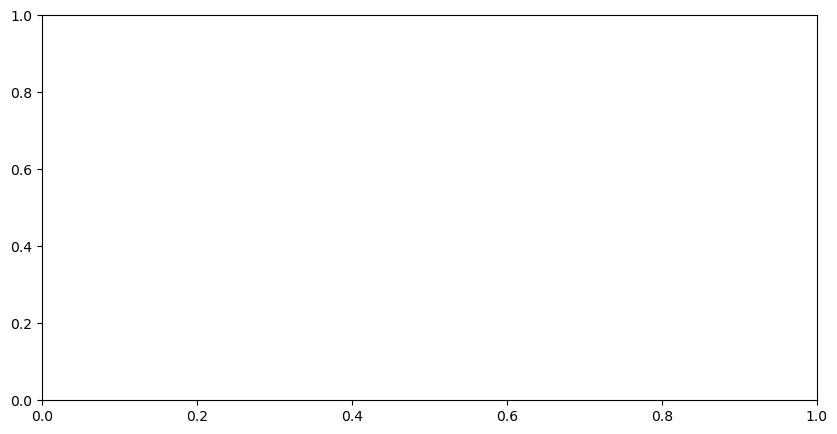

In [40]:
# Violin plot with intra-cluster similarity
pos = list(range(10))
labels = pos
plt.figure(1, figsize=(10, 5))
ax = plt.subplot(111)
r = plt.violinplot(intra_sim, pos, showmeans=True, showmedians=True, showextrema=False)
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0.6, 1., 0.1))
ax.set_title('Intra-cluster Tanimoto similarity', fontsize=13)
r['cmeans'].set_color('red')
# mean=red, median=blue
pos

In [41]:
# Get the cluster center of each cluster (first molecule in each cluster)
clus_center = [mols[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print('Number of cluster centers: ', len(clus_center))

Number of cluster centers:  539


In [43]:
# Sort the molecules within a cluster based on their similarity 
# to the cluster center and sort the clusters based on their size
clusters_sort = []
for c in clusters:
    if len(c) < 2: continue # Singletons
    else:
        # Compute fingerprints for each cluster element
        fps_clust = [rdkit_gen.GetFingerprint(mols[i][0]) for i in c]
        # Similarity of all cluster members to the cluster center
        simils = DataStructs.BulkTanimotoSimilarity(fps_clust[0],fps_clust[1:])
        # Add index of the molecule to its similarity (centroid excluded!)
        simils = [(s,index) for s,index in zip(simils, c[1:])]
        # Sort in descending order by similarity
        simils.sort(reverse=True)
        # Save cluster size and index of molecules in clusters_sort
        clusters_sort.append((len(simils), [i for s,i in simils]))
        # Sort in descending order by cluster size
        clusters_sort.sort(reverse=True)

In [45]:
# Count selected molecules, pick cluster centers first
sel_molecules = clus_center.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
diff = 1000 - len(sel_molecules)
while diff > 0  and index < len(clusters_sort):
    # Take indices of sorted clusters
    tmp_cluster = clusters_sort[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if clusters_sort[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5*len(c))+1
    if num_compounds > diff: 
        num_compounds = diff
    # Write picked molecules and their structures into list of lists called picked_fps
    sel_molecules += [mols[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    diff = 1000 - len(sel_molecules)
print('# Selected molecules: '+str(len(sel_molecules)))

# Selected molecules: 731


In [46]:
[c[0]for c in clusters_sort]

[47,
 34,
 28,
 20,
 16,
 11,
 10,
 9,
 8,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]